In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import jkbc.utils.files as f
import h5py as h5py
import jkbc.utils.preprocessing as prep
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
filename = '../../mapped_reads/mapped_reads.hdf5'
mer_size = 5
pre  = int(mer_size/2)
post = int(mer_size/2+1)
reads_range = (0, 5000)

In [4]:
def convert_to_string(lst):
    str_lst = [str(x) for x in lst]
    return ''.join(str_lst)

def make_mer_dict(lst, length):
    import itertools as iter
    combinations = list(iter.product(lst,repeat=length))
    
    mer_dict = {}
    for mer in combinations:
        mer_str = convert_to_string(mer)
        mer_dict[mer_str] = []
    
    return mer_dict

def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def flatten_(lst):
    return [item for sublist in lst for item in sublist]
    

# Read data
We read the signal 5 bases at a time (5-mer).

The mer_dict thus contains:
- 1024 keys corresponding to the possible combinations of 5-mers (4^5)
- Each key references a list of signals
- Each signal is a list of reads for an instance of the 5-mer

In [ ]:
with h5py.File(filename, 'r') as h5file:
    read_idx = list(h5file['Reads'].keys())[reads_range[0]:reads_range[1]]

In [6]:
%%time
mer_dict = make_mer_dict(range(4), mer_size)

for read_id in tqdm(read_idx):
    dac, ref_to_signal, reference = f.get_read_info_from_file(filename, read_id)
    signal = prep._standardize(dac)
    
    for mer in range(len(reference)-post):
        first = mer-pre
        last  = mer+post
        group = convert_to_string(reference[first:last])
        
        if group == '':
            continue
        
        window_range  = (ref_to_signal[first], ref_to_signal[last])
        window_signal = signal[window_range[0]:window_range[1]]
        mer_dict[group].append(window_signal)

# Making tabel for average values

In [7]:
%%time
averaged_mer_dict = {}
for key, value in tqdm(mer_dict.items()):
    mer_sum = sum([sum(inner) for inner in value])
    mer_count = sum([len(inner) for inner in value])
    if mer_count == 0:
        print(f'{key} has no examples')
        continue
    averaged_mer_dict[key] = mer_sum/mer_count

100%|██████████| 1024/1024 [00:28<00:00, 36.30it/s]

CPU times: user 27.6 s, sys: 650 ms, total: 28.3 s
Wall time: 28.2 s


In [8]:
filename = f'{mer_size}mer_values_range{reads_range}'
save_obj(averaged_mer_dict, filename)

# Statistics

In [7]:
averaged_mer_dict = load_obj('5mer_values_range(0, 20000)')

(array([ 17.,  30.,  53., 108., 140., 186., 210., 157.,  91.,  32.]),
 array([-0.98871682, -0.81189912, -0.63508143, -0.45826374, -0.28144605,
        -0.10462836,  0.07218933,  0.24900703,  0.42582472,  0.60264241,
         0.7794601 ]),
 <a list of 10 Patch objects>)

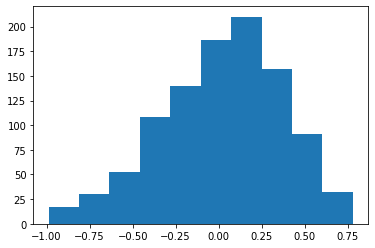

In [8]:
plt.hist(averaged_mer_dict.values())

## Find the k-mers with highest/lowest distribution
mean_distanct_mer_dict contains the sum of the distance to the mean for each 5-mer

In [9]:
mean_distanct_mer_dict = {}
for key, value in tqdm(mer_dict.items()):
    if key not in averaged_mer_dict:
        continue
    mean = averaged_mer_dict[key]
    flat_lst = flatten_(value)
    mean_distanct_mer_dict[key] = sum([abs(x-mean) for x in flat_lst])

sorted_dict = sorted(mean_distanct_mer_dict, key=mean_distanct_mer_dict.get, reverse=True)

100%|██████████| 1024/1024 [01:16<00:00, 13.44it/s]


### 5-mer with lowest variance

33122 0.10299914776452085


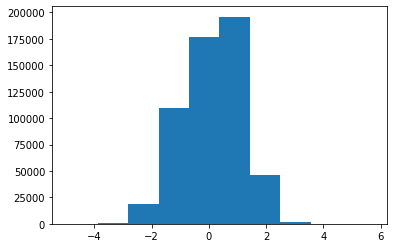

In [10]:
key = sorted_dict[0]
lst = mer_dict[key]
flat_list = flatten_(lst)
plt.hist(flat_list)
print(key, averaged_mer_dict[key])

### 5-mer with highest variance

10301 0.390913244912791


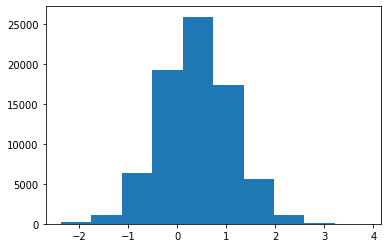

In [11]:
key = sorted_dict[-1]
lst = mer_dict[key]
flat_list = flatten_(lst)
plt.hist(flat_list)
print(key, averaged_mer_dict[key])

## Reverse k-mer is similar to original k-mer

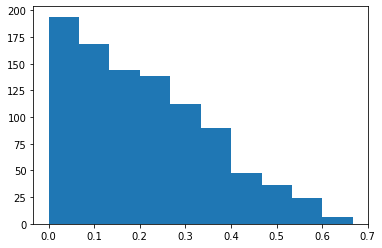

In [12]:
reverse_diff = {}
for key in averaged_mer_dict.keys():
    reverse = key[::-1]
    if reverse not in averaged_mer_dict:
        continue
    if reverse == key:
        continue
    diff = abs(averaged_mer_dict[key]-averaged_mer_dict[reverse])
    reverse_diff[key] = diff
plt.hist(reverse_diff.values())

sorted_reverse_dict = sorted(reverse_diff, key=reverse_diff.get, reverse=True)

### Most similiar original/reverse

In [13]:
key = sorted_reverse_dict[-1]
reverse_key = sorted_reverse_dict[-2]
print(key, reverse_key, reverse_diff[key])

03320 02330 6.7615579823210314e-06


03320 -0.18846710187989235


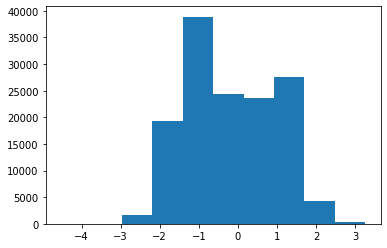

In [14]:
lst = flatten_(mer_dict[key])
plt.hist(lst)
print(key, averaged_mer_dict[key])

02330 -0.18846034032191003


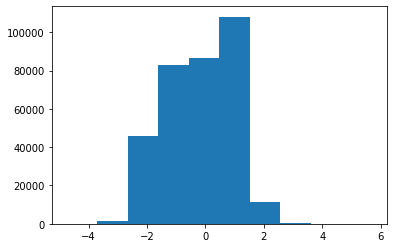

In [15]:
lst = flatten_(mer_dict[reverse_key])
plt.hist(lst)
print(reverse_key, averaged_mer_dict[reverse_key])

### Least similiar original/reverse

In [16]:
key = sorted_reverse_dict[0]
reverse_key = sorted_reverse_dict[1]
print(key, reverse_key, reverse_diff[key])

20013 31002 0.6674920161266116


20013 -0.48403573061037874


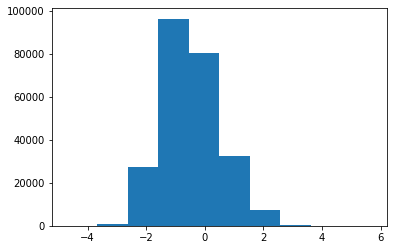

In [17]:
lst = flatten_(mer_dict[key])
plt.hist(lst)
print(key, averaged_mer_dict[key])

31002 0.18345628551623278


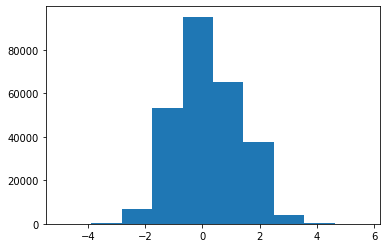

In [18]:
lst = flatten_(mer_dict[reverse_key])
plt.hist(lst)
print(reverse_key, averaged_mer_dict[reverse_key])

## Demonstrating a base's influence correspondst to its location

In [19]:
def replace_all(original, replace_with):
    original = [str(x) for x in original]
    replace_with = str(replace_with)
    kmer_swap = []
    original_str = ''.join(original)
    for index in range(len(original)):
        temp_kmer = original
        temp_kmer[index] = replace_with
        kmer_swap.append(''.join(temp_kmer))
    original_avg = averaged_mer_dict[original_str]
    means = [averaged_mer_dict[x]-original_avg for x in kmer_swap]
    
    plt.plot(kmer_swap,means)
    plt.show()

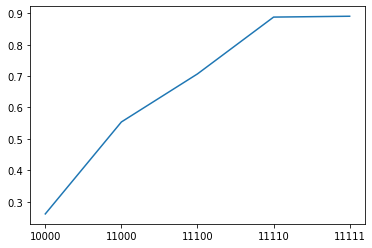

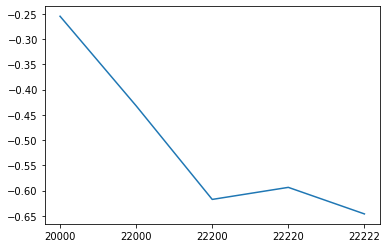

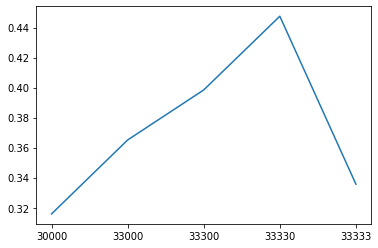

In [20]:
[replace_all([0]*5, x) for x in [1,2,3]];

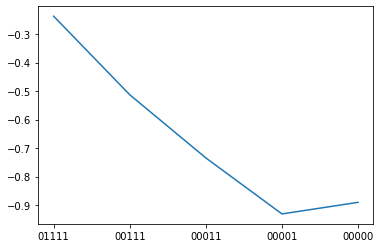

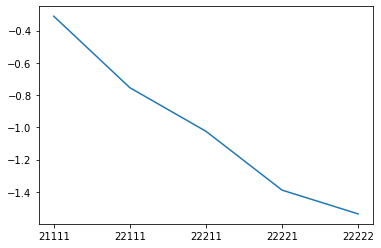

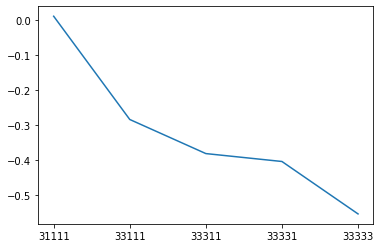

In [21]:
[replace_all([1]*5, x) for x in [0,2,3]];

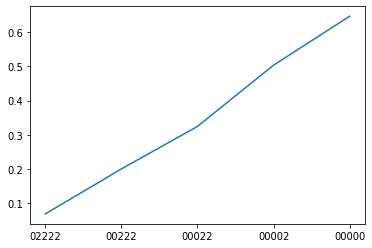

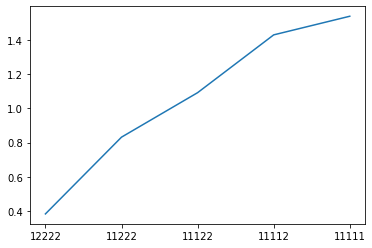

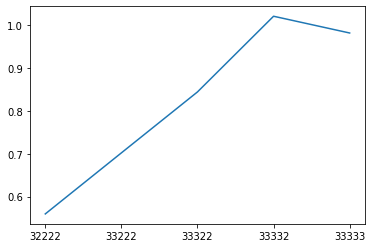

In [22]:
[replace_all([2]*5, x) for x in [0,1,3]];

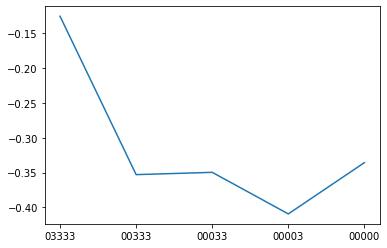

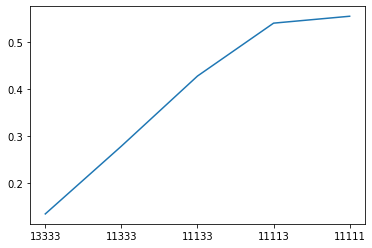

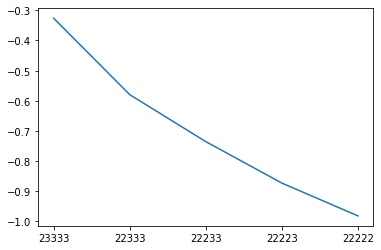

In [23]:
[replace_all([3]*5, x) for x in [0,1,2]];

In [26]:

def plot_two_sequences(seq1, seq2):
    def get_sequence(seq):
        kmers = []
        values = []
        for start in range(len(seq)-4):
            kmer = ''.join([str(x) for x in seq[start:start+5]])
            kmers.append(kmer)
            values.append(averaged_mer_dict[kmer])
        return kmers, values

    kmers1, values1 = get_sequence(seq1)
    kmers2, values2 = get_sequence(seq2)

    values_t = list(map(list, zip(*[values1, values2])))
    plt.plot(values_t)